# Imports

In [1]:
# !pip install -q wurlitzer
# !pip install -q --upgrade keras-cv tensorflow
# !pip install -q --upgrade keras

In [2]:
import keras
import tensorflow as tf
from tensorflow.keras.preprocessing import image

import os
from tqdm import tqdm

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

print('running tf: ', tf.__version__)
print('running keras: ', tf.__version__)

2024-06-23 07:22:45.023979: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-23 07:22:45.024151: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-23 07:22:45.158703: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


running tf:  2.15.0
running keras:  2.15.0


In [3]:
# os.environ["KERAS_BACKEND"] = "tensorflow"  # Or "jax" or "torch"!

# Config

In [4]:
IMG_SIZE = 224
BATCH_SIZE = 32
EPOCHS = 30

MAX_SEQ_LENGTH = 64
NUM_FEATURES = 1280

DEBUG = False
AUTOTUNE = tf.data.experimental.AUTOTUNE

# Data Loading

In [5]:
# Paths to your data
freeway_train_path = '/kaggle/input/2nd-ava-challenge-ieee-mipr-2024/2nd_AVA_Dataset_2ed/freeway/train'
road_train_path = '/kaggle/input/2nd-ava-challenge-ieee-mipr-2024/2nd_AVA_Dataset_2ed/road/train'
freeway_train_csv = '/kaggle/input/2nd-ava-challenge-ieee-mipr-2024/2nd_AVA_Dataset_2ed/freeway_train.csv'
road_train_csv = '/kaggle/input/2nd-ava-challenge-ieee-mipr-2024/2nd_AVA_Dataset_2ed/road_train.csv'

# Read CSV files
freeway_df = pd.read_csv(freeway_train_csv)
road_df = pd.read_csv(road_train_csv)

# Add the directory path to the file names
freeway_df['file_name'] = freeway_df['file_name'].apply(lambda x: os.path.join(freeway_train_path, x))
road_df['file_name'] = road_df['file_name'].apply(lambda x: os.path.join(road_train_path, x))

# Combine dataframes
all_df = pd.concat([freeway_df, road_df])

if DEBUG:
    all_df = all_df[:20]

In [6]:
# Split into train and validation sets
train_df, val_df = train_test_split(all_df, test_size=0.2, random_state=42, stratify=all_df['risk'])

print(f"Total videos for training: {len(train_df)}")
print(f"Total videos for val: {len(val_df)}")

train_df.sample(10)

Total videos for training: 287
Total videos for val: 72


,file_name,risk
75,/kaggle/input/2nd-ava-challenge-ieee-mipr-2024...,0
96,/kaggle/input/2nd-ava-challenge-ieee-mipr-2024...,0
120,/kaggle/input/2nd-ava-challenge-ieee-mipr-2024...,0
152,/kaggle/input/2nd-ava-challenge-ieee-mipr-2024...,0
67,/kaggle/input/2nd-ava-challenge-ieee-mipr-2024...,0
153,/kaggle/input/2nd-ava-challenge-ieee-mipr-2024...,0
13,/kaggle/input/2nd-ava-challenge-ieee-mipr-2024...,0
69,/kaggle/input/2nd-ava-challenge-ieee-mipr-2024...,0
14,/kaggle/input/2nd-ava-challenge-ieee-mipr-2024...,0
33,/kaggle/input/2nd-ava-challenge-ieee-mipr-2024...,0


In [7]:
def read_frames_from_folder(folder_path):
    # Get list of all frame files
    frame_files = sorted([os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith('.jpg')])
    
    # Take the last num_frames frames if there are more frames
    if len(frame_files) > MAX_SEQ_LENGTH:
        frame_files = frame_files[-MAX_SEQ_LENGTH:]
    
    frames = []
    for frame_file in frame_files:
        img = image.load_img(frame_file, target_size=(IMG_SIZE, IMG_SIZE), interpolation='bicubic', keep_aspect_ratio=True)
        img_array = image.img_to_array(img)
        frames.append(img_array)

    return np.array(frames)

# Model

In [8]:
fe = tf.keras.applications.EfficientNetV2M(
    weights='imagenet', 
    include_top=False,  
    input_shape=(IMG_SIZE, IMG_SIZE, 3), 
    pooling=None,
)

# feature_extractor = SeResNeXT(input_shape=(224,224,3), weights='imagenet', include_top=False)
# preprocess_layer = tf.keras.layers.Lambda(lambda x: preprocess_fn(x))


model = tf.keras.models.Sequential([
    tf.keras.Input((IMG_SIZE, IMG_SIZE, 3)),
#     preprocess_layer,
    fe,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(512, activation= 'relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    tf.keras.layers.Dropout(rate= 0.25, seed= 123),
    tf.keras.layers.Dense(2, activation=None)
])

model.build()

model.load_weights('/kaggle/input/mipr-ava-single-frame-models/best_model.weights.h5')

214201816/214201816 ━━━━━━━━━━━━━━━━━━━━ 7s 0us/step


In [9]:
print(model.summary())
model.layers

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetv2-m (Functional)   │ (None, 7, 7, 1280)     │    53,150,388 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 1280)           │         5,120 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       655,872 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │         1,026 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 53,812,406 (205.28 MB)

 Trainable params: 53,517,814 (204.15 MB)

 Non-trainable params: 294,592 (1.12 MB)

None


[<Functional name=efficientnetv2-m, built=True>,
 <GlobalAveragePooling2D name=global_average_pooling2d, built=True>,
 <BatchNormalization name=batch_normalization, built=True>,
 <Dense name=dense, built=True>,
 <Dropout name=dropout, built=True>,
 <Dense name=dense_1, built=True>]

In [10]:
from tensorflow.keras.models import Model

feature_extractor = Model(inputs=model.inputs, outputs=model.layers[-4].output)

In [11]:
# def build_feature_extractor():
#     feature_extractor = keras.applications.ConvNeXtSmall(
#         weights="imagenet",
#         include_top=False,
#         pooling="avg",
#         input_shape=(IMG_SIZE, IMG_SIZE, 3),
#     )
#     preprocess_input = keras.applications.convnext.preprocess_input

#     inputs = keras.Input((IMG_SIZE, IMG_SIZE, 3))
#     preprocessed = preprocess_input(inputs)

#     outputs = feature_extractor(preprocessed)
#     return keras.Model(inputs, outputs, name="feature_extractor")


# feature_extractor = build_feature_extractor()

In [12]:
feature_extractor.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetv2-m (Functional)   │ (None, 7, 7, 1280)     │    53,150,388 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 1280)           │         5,120 │
│ (BatchNormalization)            │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 53,155,508 (202.77 MB)

 Trainable params: 52,860,916 (201.65 MB)

 Non-trainable params: 294,592 (1.12 MB)

In [13]:
def prepare_all_videos(df):
    num_samples = len(df)
    video_paths = df["file_name"].values.tolist()
    labels = df["risk"].values

    # `frame_masks` and `frame_features` are what we will feed to our sequence model.
    # `frame_masks` will contain a bunch of booleans denoting if a timestep is
    # masked with padding or not.
    frame_masks = np.zeros(shape=(num_samples, MAX_SEQ_LENGTH), dtype="bool")
    frame_features = np.zeros(
        shape=(num_samples, MAX_SEQ_LENGTH, NUM_FEATURES), dtype="float32"
    )

    # For each video.
    for idx, path in enumerate(tqdm(video_paths, desc='Processing Videos')):
        # Gather all its frames and add a batch dimension.
        frames = read_frames_from_folder(path)
        frames = frames[None, ...]

        # Initialize placeholders to store the masks and features of the current video.
        temp_frame_mask = np.zeros(
            shape=(
                1,
                MAX_SEQ_LENGTH,
            ),
            dtype="bool",
        )
        temp_frame_features = np.zeros(
            shape=(1, MAX_SEQ_LENGTH, NUM_FEATURES), dtype="float32"
        )
        
        # Extract features from the frames of the current video.
        for i, batch in enumerate(frames):
            video_length = batch.shape[0]
            length = min(MAX_SEQ_LENGTH, video_length)
            for j in range(length):
                temp_frame_features[i, j, :] = feature_extractor.predict(
                    batch[None, j, :], verbose=0,
                )
            temp_frame_mask[i, :length] = 1  # 1 = not masked, 0 = masked

        frame_features[idx,] = temp_frame_features.squeeze()
        frame_masks[idx,] = temp_frame_mask.squeeze()

    return (frame_features, frame_masks), labels


train_data, train_labels = prepare_all_videos(train_df)
test_data, test_labels = prepare_all_videos(val_df)

print(f"Frame features in train set: {train_data[0].shape}")
print(f"Frame masks in train set: {train_data[1].shape}")

Processing Videos:   0%|          | 0/287 [00:00<?, ?it/s]WARNING: All log messages before absl::InitializeLog() is called are written to STDERR
I0000 00:00:1719127413.206170      66 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
Processing Videos: 100%|██████████| 72/72 [06:30<00:00,  5.43s/it]

Frame features in train set: (287, 64, 1280)
Frame masks in train set: (287, 64)


In [14]:
# Utility for our sequence model.
def get_sequence_model():
    class_vocab = np.unique(train_labels)

    frame_features_input = keras.Input((MAX_SEQ_LENGTH, NUM_FEATURES))
    mask_input = keras.Input((MAX_SEQ_LENGTH,), dtype="bool")

    # Refer to the following tutorial to understand the significance of using `mask`:
    # https://keras.io/api/layers/recurrent_layers/gru/
    x = keras.layers.GRU(16, return_sequences=True)(
        frame_features_input, mask=mask_input
    )
    x = keras.layers.GRU(8)(x)
    x = keras.layers.Dropout(0.4)(x)
    x = keras.layers.Dense(8, activation="relu")(x)
    output = keras.layers.Dense(len(class_vocab), activation="softmax")(x)

    rnn_model = keras.Model([frame_features_input, mask_input], output)

    rnn_model.compile(
        loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"]
    )
    return rnn_model

In [15]:
model = get_sequence_model()
model.summary()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 64, 1280)  │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_3       │ (None, 64)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru (GRU)           │ (None, 64, 16)    │     62,304 │ input_layer_2[0]… │
│                     │                   │            │ input_layer_3[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_1 (GRU)         │ (None, 8)         │        624 │ gru[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 8)         │          0 │ gru_1[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 8)         │         72 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 2)         │         18 │ dense_2[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 63,018 (246.16 KB)

 Trainable params: 63,018 (246.16 KB)

 Non-trainable params: 0 (0.00 B)

## Optimize & Compile

In [16]:
# ModelCheckpoint callback - to save best model from every training
checkpoint = keras.callbacks.ModelCheckpoint("best_model.keras", 
                                                save_best_only=True, 
                                                save_weights_only=False,
                                                verbose=1,
                                                monitor='val_loss', 
                                                mode='min')

learning_rate_reduction= keras.callbacks.ReduceLROnPlateau(monitor='loss',patience=2,verbose=1,factor=0.1,min_lr=0.0000000001) 

callbacks = [checkpoint, learning_rate_reduction]

In [17]:
# model.compile(
#     optimizer=keras.optimizers.Adam(learning_rate=2e-3, weight_decay=None),
#     loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
#     metrics=[
#         keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
#     ],
# )

## Train Model

In [18]:
history = model.fit(
    [train_data[0], train_data[1]],
    train_labels,
    validation_data=([test_data[0], test_data[1]], test_labels),
    epochs=EPOCHS,
    callbacks=callbacks,
)

Epoch 1/30
5/9 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7103 - loss: 0.6092
Epoch 1: val_loss improved from inf to 0.69441, saving model to best_model.keras
9/9 ━━━━━━━━━━━━━━━━━━━━ 5s 62ms/step - accuracy: 0.7612 - loss: 0.5668 - val_accuracy: 0.6250 - val_loss: 0.6944 - learning_rate: 0.0010
Epoch 2/30
6/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9136 - loss: 0.3935
Epoch 2: val_loss did not improve from 0.69441
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9181 - loss: 0.3840 - val_accuracy: 0.6528 - val_loss: 0.7141 - learning_rate: 0.0010
Epoch 3/30
6/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9654 - loss: 0.3088
Epoch 3: val_loss did not improve from 0.69441
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9548 - loss: 0.3089 - val_accuracy: 0.6667 - val_loss: 0.7339 - learning_rate: 0.0010
Epoch 4/30
6/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9412 - loss: 0.2939
Epoch 4: val_loss did not improve from 0.69441
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms

In [19]:
model.save('zero-model.keras')

## Plots

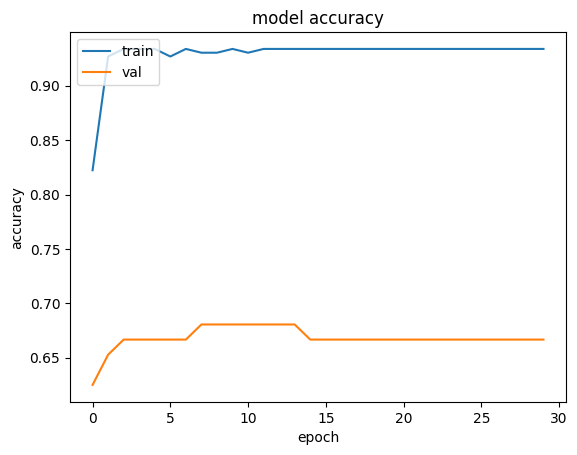

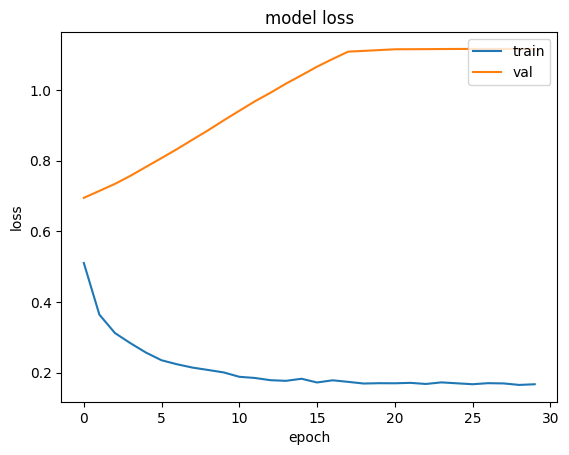

In [20]:
plt.figure(1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')

plt.figure(2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

# Inference

In [21]:
model = keras.models.load_model('best_model.keras')

In [22]:
# Load the sample submission file
submission_df = pd.read_csv('/kaggle/input/2nd-ava-challenge-ieee-mipr-2024/2nd_AVA_Dataset_2ed/sample_submission.csv')

# Paths to test data
freeway_test_path = '/kaggle/input/2nd-ava-challenge-ieee-mipr-2024/2nd_AVA_Dataset_2ed/freeway/test'
road_test_path = '/kaggle/input/2nd-ava-challenge-ieee-mipr-2024/2nd_AVA_Dataset_2ed/road/test'

# Function to add root folder path
def add_root_folder(file_name):
    if 'freeway' in file_name:
        return os.path.join(freeway_test_path, file_name)
    elif 'road' in file_name:
        return os.path.join(road_test_path, file_name)
    else:
        print('BUG ALERT! -- ', filename)

# Apply the function to the dataframe
submission_df['file_path'] = submission_df['file_name'].apply(add_root_folder)

if DEBUG:
    submission_df = submission_df[:5]

In [23]:
def prepare_single_video(frames):
    frames = frames[None, ...]
    frame_mask = np.zeros(
        shape=(
            1,
            MAX_SEQ_LENGTH,
        ),
        dtype="bool",
    )
    frame_features = np.zeros(shape=(1, MAX_SEQ_LENGTH, NUM_FEATURES), dtype="float32")

    for i, batch in enumerate(frames):
        video_length = batch.shape[0]
        length = min(MAX_SEQ_LENGTH, video_length)
        for j in range(length):
            frame_features[i, j, :] = feature_extractor.predict(batch[None, j, :], verbose = 0)
        frame_mask[i, :length] = 1  # 1 = not masked, 0 = masked

    return frame_features, frame_mask


def sequence_prediction(path):
    frames = read_frames_from_folder(path)
    frame_features, frame_mask = prepare_single_video(frames)
    probabilities = model.predict([frame_features, frame_mask], verbose = 0)[0]

    return probabilities

In [24]:
# Run inference
def run_inference(filepaths):
    predictions = []
    for path in tqdm(filepaths):
        probs = sequence_prediction(path)
        predictions.append(probs[1])
    return predictions


test_filepaths = submission_df['file_path'].values.tolist()
predictions = run_inference(test_filepaths)

100%|██████████| 243/243 [21:28<00:00,  5.30s/it]


In [25]:
submission_df['risk'] = predictions

submission_df = submission_df.drop(['file_path'], axis = 1)

submission_df

,file_name,risk
0,road_0179,0.262199
1,road_0180,0.689144
2,road_0181,0.276715
3,road_0182,0.484519
4,road_0183,0.484519
...,...,...
238,freeway_0297,0.429414
239,freeway_0298,0.606085
240,freeway_0299,0.817255
241,freeway_0300,0.722422


In [26]:
# Save the updated submission file
submission_df.to_csv('submission.csv', index=False)